In [50]:
from metpy.io import Level2File
from metpy.calc.tools import azimuth_range_to_lat_lon
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pydrology.nexrad_processing import nexrad_datetime

(721, 1833)
(720, 1832)
(721, 1833)
(720, 1832)
(721, 1833)
(720, 1832)
(721, 1833)
(720, 1832)
(721, 1833)
(720, 1832)


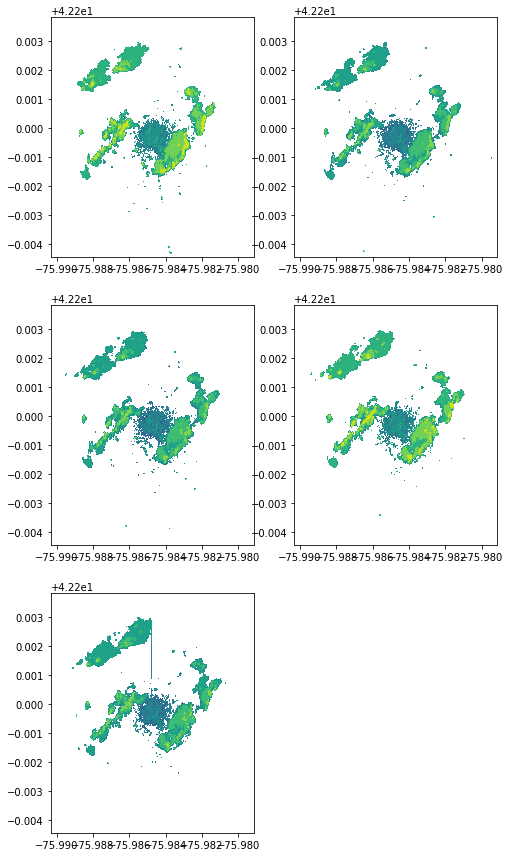

In [55]:
fdir = r"~/Path to Directory/NEXRAD_Output/2022-07-25"
fps = [(nexfp, nexrad_datetime(nexfp)) for nexfp in Path(fdir).glob('**/*') if str(nexfp)[-3:] == 'V06']
fps.sort(key=lambda x: x[1])
fps = [fp[0] for fp in fps]

fig = plt.figure(figsize=(8,15))
spec = gridspec.GridSpec(3, 2)
lat_grids = np.zeros((720, 1832, 5))
for i in range(5):
    fp = fps[i]
    nexrad_filepath = fp

    # Load the file.
    f = Level2File(nexrad_filepath)

    # Pull data out of the file
    sweep = 0

    # First item in ray is header, which has azimuth angle
    az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])
    diff = np.diff(az)
    diff[diff > 180] -= 360.
    diff[diff < -180] += 360.
    avg_spacing = diff.mean()
    az = (az[:-1] + az[1:]) / 2
    az = np.concatenate(([az[0] - avg_spacing], az, [az[-1] + avg_spacing]))

    center_lat = f.sweeps[sweep][0][1].lat
    center_lon = f.sweeps[sweep][0][1].lon

    # 5th item is a dict mapping a var name (byte string) to a tuple
    # of (header, data array)
    ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
    ref_range = (np.arange(ref_hdr.num_gates + 1) - 0.5) * ref_hdr.gate_width + ref_hdr.first_gate
    ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

    # Latitude and longitudes from the azimuth and range.
    ref_lons, ref_lats = azimuth_range_to_lat_lon(az, ref_range, center_lon, center_lat)

    print(ref_lons.shape)
    print(ref.shape)

    # Get the centers of the lat and lon grids. 
    ref_lons_grid = (ref_lons[1:,1:] + ref_lons[:-1,:-1]) / 2
    ref_lats_grid = (ref_lats[1:,1:] + ref_lats[:-1,:-1]) / 2
    
    lat_grids[:,:,i] = ref_lats_grid
    
    ax = fig.add_subplot(spec[i])
    ax.contourf(ref_lons_grid, ref_lats_grid, ref)
    # plt.pcolormesh(ref_lons, ref_lats, ref, cmap='viridis')